# Introduction
In this notebook, we're going to make use of the k-means clustering algorithm to segment customers based on buying behaviour for a retail store.

The dataset we're going to make use of is the `UCI Machine Learning Retail Dataset`. The dataset is a transactional data that contains transactions from December 1st 2010 until December 9th 2011 for a UK-based online retail. 

Let's dive right in:

In [ ]:
from google.colab import files

files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_excel('/content/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
len(df)

541909

# Data Cleaning
Let's perform some data cleaning.

In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
len(df)

406829

Let's take a look at the `Quantity` and the `UnitPrice` columns to ensure that no value is 0 or -ve (you cant buy -1 items, price of items shouldn't be 0).



In [ ]:
df.groupby(['Quantity']).count()

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country
Quantity,,,,,,,
-80995,1,1,1,1,1,1,1
-74215,1,1,1,1,1,1,1
-9360,1,1,1,1,1,1,1
-3114,1,1,1,1,1,1,1
-2000,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
4300,1,1,1,1,1,1,1
4800,1,1,1,1,1,1,1
12540,1,1,1,1,1,1,1


We can see that there are various rows with -ve quantities. Since we can't say for sure what this means, let's drop such rows.

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy = df_copy[ df_copy['Quantity']>0 ]

In [ ]:
len(df_copy)

397924

Let's do the same for unit price

In [ ]:
df.groupby(['UnitPrice']).count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country
UnitPrice,,,,,,,
0.000,40,40,40,40,40,40,40
0.001,4,4,4,4,4,4,4
0.010,1,1,1,1,1,1,1
0.030,3,3,3,3,3,3,3
0.040,66,66,66,66,66,66,66
...,...,...,...,...,...,...,...
4161.060,3,3,3,3,3,3,3
4287.630,1,1,1,1,1,1,1
6930.000,1,1,1,1,1,1,1


We'll drop all  sales with unit prices of 0; maybe there were for-free gift items.

In [ ]:
df_copy = df_copy[ df_copy['UnitPrice']>0 ]

In [ ]:
len(df_copy)

397884

Let's now take a look at the InvoiceDate column.

In [ ]:
df_copy['InvoiceDate'].dtype

dtype('<M8[ns]')

We'll convert this column to be datetime objects in the next section.

# Segmentation
For our segmentation task, we're going to group our customers using three metrics. These are customer's `Recency`, `Frequency` and `Monetary Value`.

`Recency` indicates how recently the customer purchased an item.

`Frequency` denotes how often the customer makes purchases.

`Monetary Value` indicates how much the customer spends.

Let's now generate these three metrics from our data:




## Recency:
To get the Recency metric for each customer, we assume that we're performing this segmentation a day after the last record was collected.

Hence, using our assumed date, we'll compute the difference in days from the day of purchase till our assumed date.

In [ ]:
from datetime import datetime

In [ ]:
df_copy["InvoiceDate"] = df_copy["InvoiceDate"].dt.date
# convert invoice date column to datetime object

In [ ]:
max(df_copy.InvoiceDate)

datetime.date(2011, 12, 9)

In [ ]:
import datetime

In [ ]:
rec_day = max(df_copy.InvoiceDate) + datetime.timedelta(days=1)

In [ ]:
rec_day

datetime.date(2011, 12, 10)

## Frequency
To compute the Frequency, we'll group the data by customer and count the number of transactions for each customer.

In [ ]:
df_copy.groupby(['CustomerID']).count().loc[:, ['InvoiceNo']]

,InvoiceNo
CustomerID,
12346.0,1
12347.0,27
12348.0,5
12349.0,15
12350.0,2
...,...
18278.0,2
18281.0,2
18282.0,1


# Monetary Value
To compute this metric, we'll also need to group the data by cutomers and compute the sum.

In [ ]:
df_copy.groupby(['CustomerID']).sum().loc[:, ['Quantity', 'UnitPrice']]

,Quantity,UnitPrice
CustomerID,,
12346.0,74215,1.04
12347.0,310,72.70
12348.0,462,42.45
12349.0,84,370.35
12350.0,18,5.05
...,...,...
18278.0,10,9.20
18281.0,13,17.37
18282.0,2,6.75


The monetary value is the product of quantity and unit price.

The best approach would be to group the data by customerID and then compute the three metrics to get a much nicer representation.

In [ ]:
df_copy["TotalSum"] = df_copy["Quantity"] * df_copy["UnitPrice"]

In [ ]:
customers = df_copy.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (rec_day - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

In [ ]:
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [ ]:
len(customers)

4338

In [ ]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


# Data Preprocessing and Visualization
In order to make our k-means clustering algorithm effective, we have to ensure that our data has the same mean and variance and it is not skewed.

In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'Recency Distribution')

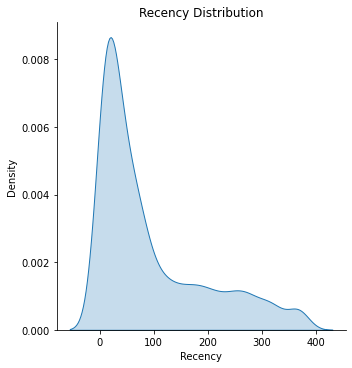

In [ ]:
sns.displot(data=customers, x='Recency', kind='kde', fill=True)
plt.title("Recency Distribution")


Text(0.5, 1.0, 'Frequency Distribution')

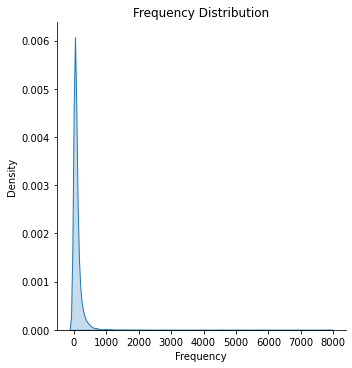

In [ ]:
sns.displot(data=customers, x='Frequency', kind='kde', fill=True)
# plt.xlim(-50, 300)
plt.title("Frequency Distribution")

Text(0.5, 1.0, 'Monetary-Value Distribution')

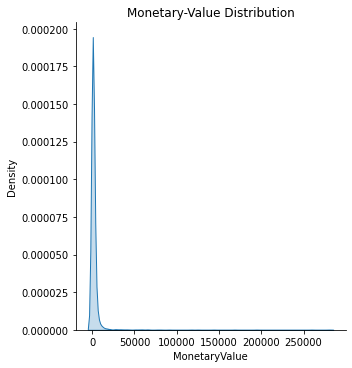

In [ ]:
sns.displot(data=customers, x='MonetaryValue', kind='kde', fill=True)
#plt.xlim(0, 8000)
plt.title("Monetary-Value Distribution")

As we can see the data is very skewed, let's apply log transformations and see the results.

Text(0.5, 1.0, 'Log Recency Distribution')

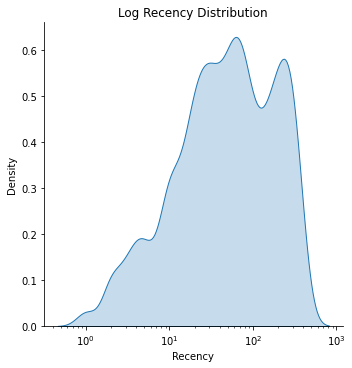

In [ ]:
sns.displot(data=customers, x='Recency', kind='kde',log_scale=10, fill=True)
plt.title("Log Recency Distribution")

Text(0.5, 1.0, 'Log Frequency Distribution')

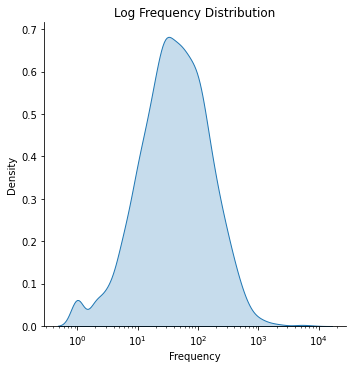

In [ ]:
sns.displot(data=customers, x='Frequency', kind='kde',log_scale=10, fill=True)
#plt.xlim(-50, 300)
plt.title("Log Frequency Distribution")

Text(0.5, 1.0, 'Log Monetary Value Distribution')

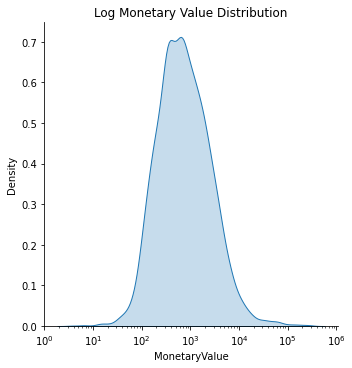

In [ ]:
sns.displot(data=customers, x='MonetaryValue', kind='kde',log_scale=10, fill=True)
#plt.xlim(-50, 300)
plt.title("Log Monetary Value Distribution")

As we can see from the above plots, we've been able to transform the data to obtain normal distributions (but only for Frequency and Monetary Value).

Let's try the box-cox transformation to see how it'll do.

In [ ]:
from scipy import stats

In [ ]:
c_copy = customers.copy()

In [ ]:
box_cox_customer = stats.boxcox(c_copy['Recency'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Box-cox Recency Distribution')

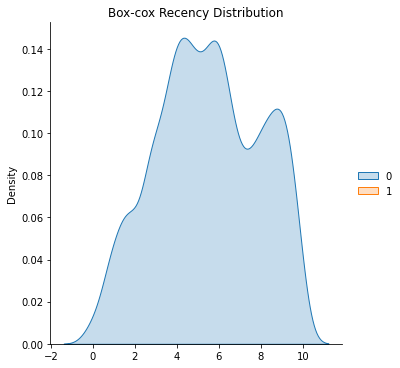

In [ ]:
sns.displot(data=box_cox_customer, kind='kde', fill=True)
plt.title("Box-cox Recency Distribution")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Box-cox Monetary Value Distribution')

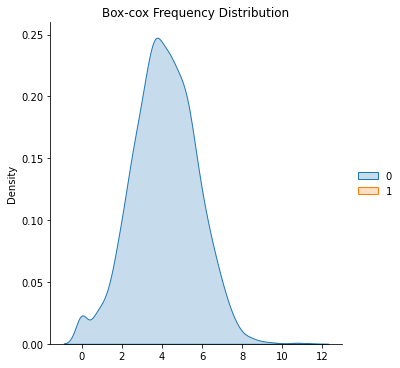

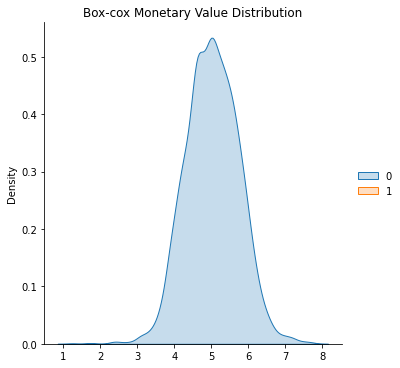

In [ ]:
box_cox_customer_F = stats.boxcox(c_copy['Frequency'])
box_cox_customer_M = stats.boxcox(c_copy['MonetaryValue'])

sns.displot(data=box_cox_customer_F, kind='kde', fill=True)
plt.title("Box-cox Frequency Distribution")

sns.displot(data=box_cox_customer_M, kind='kde', fill=True)
plt.title("Box-cox Monetary Value Distribution")

There doesn't seem to be much difference. So I'll stick with the log-transformations. Let's  transform the dataframe and then calculate the skewness for each feature.

In [ ]:
customers_log = c_copy.apply(np.log10)

In [ ]:
customers_log.skew()

Recency         -0.467237
Frequency       -0.218240
MonetaryValue    0.380936
dtype: float64

Here is how to interpret the skewness value: For each feature, if the value is close to 0, the feature tends to have symmetrical form. However, if it’s not, the feature is skewed. For our case, this values are quite close to 0. So we're good to go.

In [ ]:
customers_log.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,2.513218,0.000000,4.887525
12347.0,0.477121,2.260071,3.634477
12348.0,1.880814,1.491362,3.254606
12349.0,1.278754,1.863323,3.244908
12350.0,2.492760,1.230449,2.524266


Now we're done with skewness. Next, we have to ensure that our data has the same mean and variance (is normailzed) before feeding it to our model.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
norm_customers = scaler.fit_transform(customers_log)

In [ ]:
# Assert that it has mean 0 and variance 1
print(norm_customers.mean(axis = 0).round(2)) # [0. -0. 0.]
print(norm_customers.std(axis = 0).round(2)) # [1. 1. 1.]

[-0.  0.  0.]
[1. 1. 1.]


# KMeans Model
Now it's time to use the KMeans clustering algorithm to segment our data. The KMeans algo works by grouping data into K distinct groups using the centroid of each K group.

According to Wikipedia, "k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster."

How many clusters (customer segments) should we have? Well, we do not know. We have to find out from the data. One method of finding out is by using the elbow method.

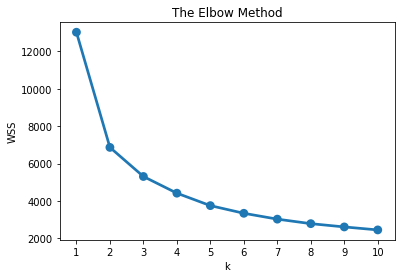

In [ ]:
from sklearn.cluster import KMeans

wss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(norm_customers)
    wss[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('WSS')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

The Elbow method looks at the total `within-cluster sum of squares` (WSS) as a function of the number of clusters. The total WSS measures the compactness of the clustering and we want it to be as small as possible. One should choose a number of clusters so that adding another cluster doesn’t improve much better the total WSS.

In our case, let's make use of 3 clusters (k=3).

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(norm_customers)
model.labels_.shape

(4338,)

We can summarize the RFM table based on clusters and calculate the mean of each variable.

In [ ]:
customers["Cluster"] = model.labels_

customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         67.91     64.68       1148.04  1864
1        174.69     15.05        296.22  1507
2         14.32    263.32       6540.91   967

From the above table, we can say that cluster 0 spends around 1k pounds, 1 spends 300 pounds and 2 spends about 6k+ quid.

# Cluster Visualization. 
Let's visualize the clusters. Before that, we will use the scaled data to perform this visualization. Let's create a dataframe from this nd-array.

In [ ]:
# Create the dataframe
df_normalized = pd.DataFrame(norm_customers, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_


In [ ]:
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,1.435416,-2.775160,3.698719,12346.0,0
1,-1.953393,1.149549,1.410201,12347.0,2
2,0.382865,-0.185347,0.716419,12348.0,0
3,-0.619183,0.460579,0.698706,12349.0,0
4,1.401368,-0.638433,-0.617446,12350.0,1


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

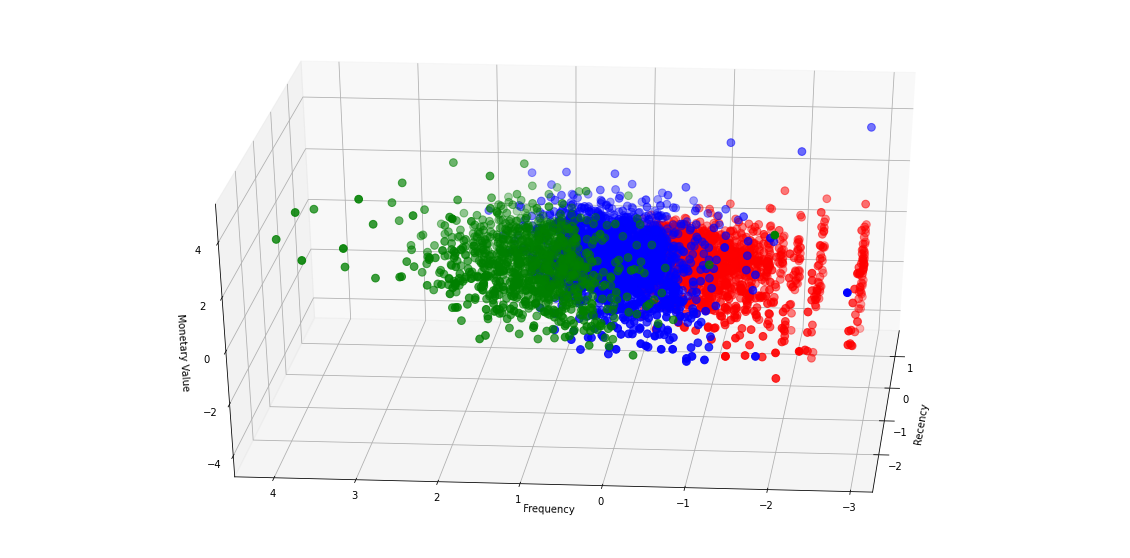

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_normalized.Recency[df_normalized.Cluster == 0], df_normalized["Frequency"][df_normalized.Cluster == 0], df_normalized["MonetaryValue"][df_normalized.Cluster == 0], c='blue', s=60)
ax.scatter(df_normalized.Recency[df_normalized.Cluster == 1], df_normalized["Frequency"][df_normalized.Cluster == 1], df_normalized["MonetaryValue"][df_normalized.Cluster == 1], c='red', s=60)
ax.scatter(df_normalized.Recency[df_normalized.Cluster == 2], df_normalized["Frequency"][df_normalized.Cluster == 2], df_normalized["MonetaryValue"][df_normalized.Cluster == 2], c='green', s=60)

ax.view_init(30, 185)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary Value')
plt.show()

The above 3d plot doesn't tell us much, we'll make use of other plots to better visualize the data.

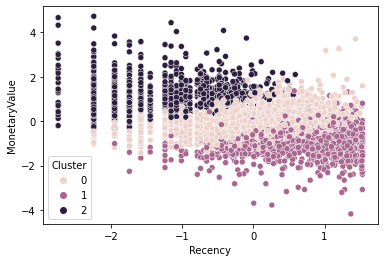

In [ ]:
sns.scatterplot(x="Recency", y="MonetaryValue", hue='Cluster', data=df_normalized)

plt.xlabel("Recency")
plt.ylabel("MonetaryValue")

plt.show()

This 2-d plot doesn't show us much; Let's make use of a `snakeplot`.

In [ ]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12346.0,0,Recency,1.435416
1,12347.0,2,Recency,-1.953393
2,12348.0,0,Recency,0.382865
3,12349.0,0,Recency,-0.619183
4,12350.0,1,Recency,1.401368


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


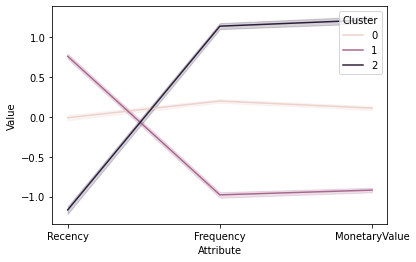

In [ ]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

From the above plot, we can infer that:
- Cluster 0 last visited a while ago, isn't frequent and spends a fair bit of money. This can be seen as maybe a New Customer or maybe just the one time customers??

- Cluster 1 has not shopped in a while, doesn't come very often and did not spend much. This can be churned out customers??

- Cluster 2 has been recent, very frequent and spends  relatively the most money. This can be seen as the loyal customers??



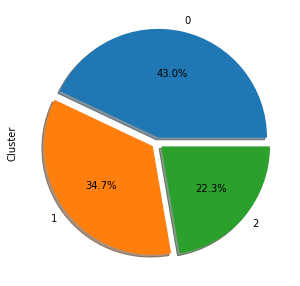

In [ ]:
plt.figure(figsize=(8,5))
df_normalized['Cluster'].value_counts().plot.pie(explode=[0.05,0.05,0.05], autopct='%1.1f%%',shadow=True)

# Inference:

From the above chart, we can then infer that 43% of the customers may be new or only visited once.

34.7% of the customers have been churned out

22.3% of the customers have continually returned to make purchases.

Also from the summary table in the final part of the model section, we can clearly see that the most amount of money is brought in by the "Loyal Customers" (22% of the total customers).

# Conclusion
In this notebook, we've successfully been able to segment customers of a certain UK Retail store into 3 groups.

# Reference:
- https://en.wikipedia.org/wiki/RFM_(market_research)
- https://archive.ics.uci.edu/ml/machine-learning-databases/00352/ (dataset)
- https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945
- https://www.kdnuggets.com/2019/11/customer-segmentation-using-k-means-clustering.html
- https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/